# TP 2 : Apprentissage de champ de vecteur

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


from scipy.integrate import solve_ivp

## Partie 1. (apprentissage direct)

1. 

In [2]:
def make_data(nb_data):
    x_train = 2 * torch.rand(nb_data, 2, dtype=torch.double)
    x1 = x_train[:, 0]
    x2 = x_train[:, 1]
    v1 = x1 - x1 * x2
    v2 = x1 * x2 - x2
    v_train = torch.stack([v1, v2], dim=1)
    return x_train, v_train

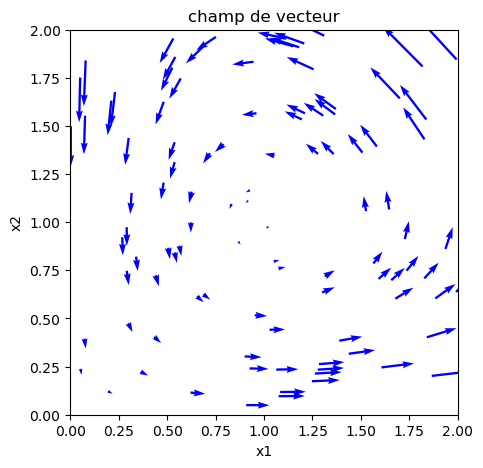

In [3]:
def test_make_data():
    nb_data = 100
    x_train, v_train = make_data(nb_data)
    x_train_np = x_train.numpy()
    v_train_np = v_train.numpy()
    plt.figure(figsize=(5, 5))
    plt.quiver(x_train_np[:, 0], x_train_np[:, 1],
               v_train_np[:, 0], v_train_np[:, 1],
               color='b')
    plt.title("champ de vecteur")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(0, 2)
    plt.ylim(0, 2)
    plt.show()

test_make_data()


In [4]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range(len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range(len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs

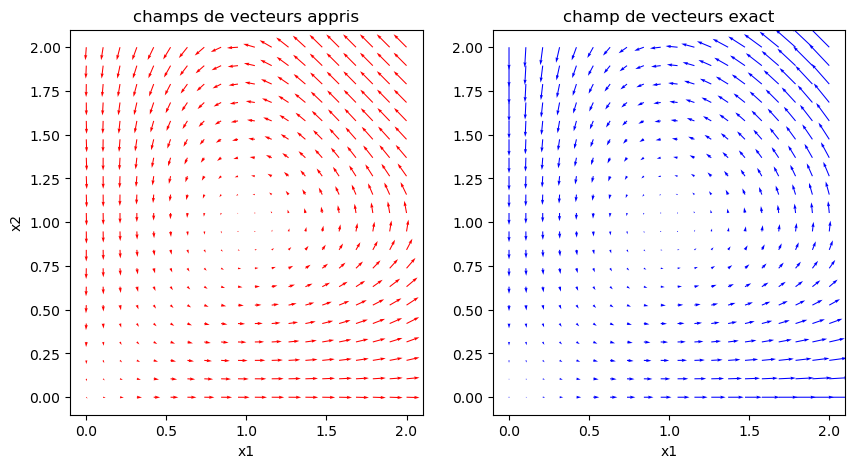

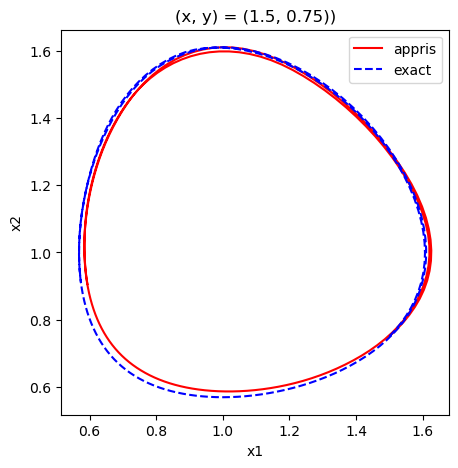

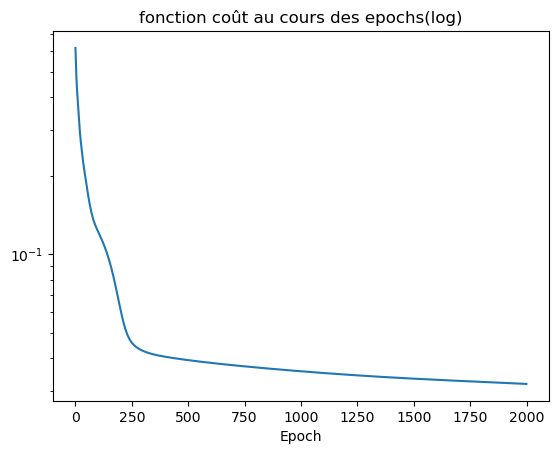

In [5]:
class vectorfield_learning:
    def __init__(self, nb_epochs=1000, lr=1e-3):
        layer_widths = [2, 50, 50, 2]
        self.network = mlp(layer_widths)
        self.nb_epochs = nb_epochs
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)

    def train(self, x_train, v_train):
        self.network.train()
        losses = []
        for epoch in range(self.nb_epochs):
            self.optimizer.zero_grad()
            output = self.network(x_train)
            loss = self.criterion(output, v_train)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
        return losses
    
    def plot(self):
        self.network.eval()
        x1 = np.linspace(0, 2, 20)
        x2 = np.linspace(0, 2, 20)
        X1, X2 = np.meshgrid(x1, x2)

        X_test = np.vstack([X1.ravel(), X2.ravel()]).T
        X_test_tensor = torch.from_numpy(X_test).double()
        
        with torch.no_grad():
            v_pred = self.network(X_test_tensor).numpy()

        x1_exact = X_test[:,0]
        x2_exact = X_test[:,1]
        v1_exact = x1_exact - x1_exact * x2_exact
        v2_exact = x1_exact * x2_exact - x2_exact

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.quiver(X_test[:, 0], X_test[:, 1], v_pred[:, 0], v_pred[:, 1],
                   color='r')
        plt.title("champs de vecteurs appris")
        plt.xlabel("x1")
        plt.ylabel("x2")
        
        plt.subplot(1, 2, 2)
        plt.quiver(X_test[:, 0], X_test[:, 1], v1_exact, v2_exact,
                   color='b')
        plt.title("champ de vecteurs exact")
        plt.xlabel("x1")
        plt.show()
        
        def f_appris(t, x):
            x_tensor = torch.tensor(x, dtype=torch.double)
            with torch.no_grad():
                v = self.network(x_tensor).numpy()
            return v
        
        def f_exact(t, x):
            x1, x2 = x
            return [x1 - x1 * x2, x1 * x2 - x2]
        
        t_span = (0, 10)
        x0 = [1.5, 0.75]
        t_eval = np.linspace(0, 10, 200)
        sol_appris = solve_ivp(f_appris, t_span, x0, t_eval=t_eval)
        sol_exact = solve_ivp(f_exact, t_span, x0, t_eval=t_eval)

        plt.figure(figsize=(5, 5))
        plt.plot(sol_appris.y[0], sol_appris.y[1], 'r-', label='appris')
        plt.plot(sol_exact.y[0], sol_exact.y[1], 'b--', label='exact')
        plt.title("(x, y) = (1.5, 0.75))")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.show()
        
    
def test_vector_field_learning():
    nb_data = 1000
    x_train, v_train = make_data(nb_data)
    model = vectorfield_learning(nb_epochs=2000, lr=1e-3)
    losses = model.train(x_train, v_train)
    model.plot()

    plt.figure()
    plt.plot(losses)
    plt.title("fonction coût au cours des epochs(log)")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.show()

test_vector_field_learning()

## Partie 2. (approche Hamiltonienne)

In [6]:
# 7
def make_data_qp(nb_data):
    x_train, v_train = make_data(nb_data)
    qp_train = torch.log(x_train)
    q = qp_train[:, 0]
    p = qp_train[:, 1]
    vqp1 = 1 - torch.exp(p)      # q' = 1 - exp(p)
    vqp2 = torch.exp(q) - 1      # p' = exp(q) - 1
    v_qp_train = torch.stack([vqp1, vqp2], dim=1)
    return x_train, qp_train, v_train, v_qp_train

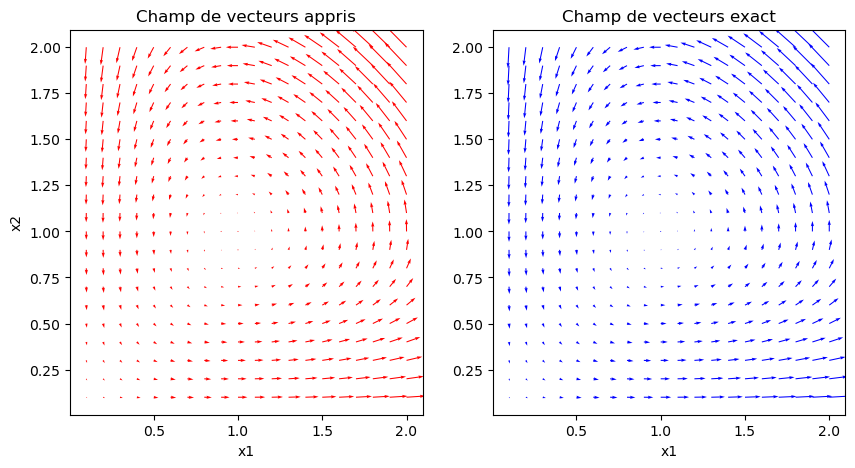

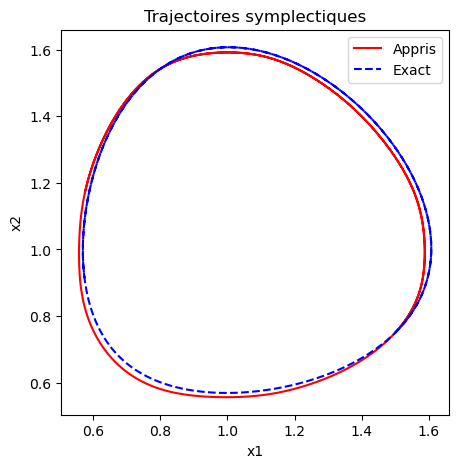

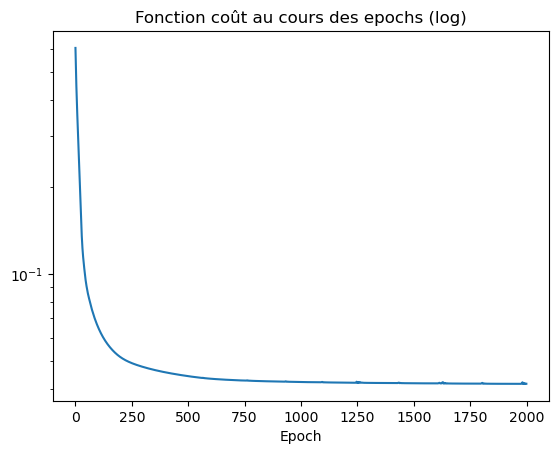

In [7]:
class separableHamiltonian_learning:
    def __init__(self, nb_epochs=1000, lr=1e-3):
        # Q8
        self.nb_epochs = nb_epochs
        self.network_q = mlp([1, 50, 50, 1])  # Réseau pour approximer H1(q)
        self.network_p = mlp([1, 50, 50, 1])  # Réseau pour approximer H2(p)
        self.criterion = nn.MSELoss()
        params = list(self.network_q.parameters()) + list(self.network_p.parameters())
        self.optimizer = optim.Adam(params, lr=lr)
    
    def train(self, qp_train, v_qp_train):
        # Q9 : Entraînement du modèle
        q = qp_train[:, 0:1].clone().detach().requires_grad_(True)
        p = qp_train[:, 1:2].clone().detach().requires_grad_(True)
        target_q_dot = v_qp_train[:, 0:1]
        target_p_dot = v_qp_train[:, 1:2]
        losses = []
        for _ in range(self.nb_epochs):
            self.optimizer.zero_grad()
            H1 = self.network_q(q)
            H2 = self.network_p(p)

            dH1 = torch.autograd.grad(H1.sum(), q, create_graph=True)[0]
            dH2 = torch.autograd.grad(H2.sum(), p, create_graph=True)[0]

            pred_q_dot = dH2           # q' = dH2/dp
            pred_p_dot = -dH1          # p' = - dH1/dq
            loss = self.criterion(pred_q_dot, target_q_dot) + self.criterion(pred_p_dot, target_p_dot)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
        return losses
    
    def dHq(self, q_val):
        # Q12 : Calcul de la dérivée dHq
        q_t = torch.tensor([q_val], dtype=torch.double, requires_grad=True)
        H1 = self.network_q(q_t)
        dH1 = torch.autograd.grad(H1, q_t)[0]
        return dH1.detach().numpy()
    
    def dHp(self, p_val):
        # Q12 : Calcul de la dérivée dHp
        p_t = torch.tensor([p_val], dtype=torch.double, requires_grad=True)
        H2 = self.network_p(p_t)
        dH2 = torch.autograd.grad(H2, p_t)[0]
        return dH2.detach().numpy()
    
    def plot(self):
        # Q11 : Affichage du champ de vecteurs
        x1 = np.linspace(0.1, 2, 20)
        x2 = np.linspace(0.1, 2, 20)
        X1, X2 = np.meshgrid(x1, x2)
        X = np.vstack([X1.ravel(), X2.ravel()]).T
        qp = np.log(X)
        q_vals = qp[:, 0]
        p_vals = qp[:, 1]

        dHp_vals = np.array([self.dHp(pi)[0] for pi in p_vals])
        dHq_vals = np.array([self.dHq(qi)[0] for qi in q_vals])
        q_dot = dHp_vals
        p_dot = -dHq_vals

        vx = np.exp(q_vals) * q_dot
        vy = np.exp(p_vals) * p_dot
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.quiver(X[:, 0], X[:, 1], vx, vy, color='r')
        plt.title("Champ de vecteurs appris")
        plt.xlabel("x1")
        plt.ylabel("x2")
        
        v1_exact = X[:, 0] - X[:, 0] * X[:, 1]
        v2_exact = X[:, 0] * X[:, 1] - X[:, 1]
        plt.subplot(1, 2, 2)
        plt.quiver(X[:, 0], X[:, 1], v1_exact, v2_exact, color='b')
        plt.title("Champ de vecteurs exact")
        plt.xlabel("x1")
        plt.show()
        
        # Q14
        t_span = (0, 10)
        dt = 0.01
        x0 = [1.5, 0.75]
        traj_appris = solve_symplectic(self.dHq, self.dHp, t_span, x0, dt, learned=True)

        def dHq_exact(q): 
            return np.array([1 - np.exp(q)])
        def dHp_exact(p): 
            return np.array([1 - np.exp(p)])
        traj_exact = solve_symplectic(dHq_exact, dHq_exact, t_span, x0, dt, learned=False)  
        
        plt.figure(figsize=(5, 5))
        plt.plot(traj_appris[:, 0], traj_appris[:, 1], 'r-', label='Appris')
        plt.plot(traj_exact[:, 0], traj_exact[:, 1], 'b--', label='Exact')
        plt.title("Trajectoires symplectiques")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.show()

def solve_symplectic(dHq, dHp, time_interv, x0, dt, learned=True):
    # Q13 : Schéma d'Euler symplectique
    t0, tf = time_interv
    n_steps = int((tf - t0) / dt)
    traj = np.zeros((n_steps + 1, 2))
    traj[0] = x0
    q = np.log(x0[0])
    p = np.log(x0[1])
    for k in range(n_steps):
        dp = dHp(p)[0]
        q_new = q + dt * dp
        dq = dHq(q_new)[0]
        p_new = p - dt * dq
        q, p = q_new, p_new
        traj[k + 1] = [np.exp(q), np.exp(p)]
    return traj

def test_separableHamiltonian_learning():
    # Q7
    nb_data = 1000
    x_train, qp_train, v_train, v_qp_train = make_data_qp(nb_data)
    model = separableHamiltonian_learning(nb_epochs=2000, lr=1e-3)
    losses = model.train(qp_train, v_qp_train)
    model.plot()
    plt.figure()
    plt.plot(losses)
    plt.title("Fonction coût au cours des epochs (log)")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.show()

test_separableHamiltonian_learning()
